<a href="https://colab.research.google.com/github/CJP123/goat_island/blob/master/Counting_Snapping_Shrimp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2
!pip install torchaudio
!pip install git+https://github.com/fastai/fastai2
!pip install git+https://github.com/fastai/fastcore
!pip install packaging
!pip install git+https://github.com/rbracco/fastai2_audio.git

     |████████████████████████████████| 3.2MB 2.8MB/s 
  Cloning https://github.com/fastai/fastai2 to /tmp/pip-req-build-dqd3k6p_
  Running command git clone -q https://github.com/fastai/fastai2 /tmp/pip-req-build-dqd3k6p_
  Created wheel for fastai2: filename=fastai2-0.0.18-cp36-none-any.whl size=193974 sha256=0d0660a091aac222810cf905794b25cc1ff9ef50704bfa0cfd524618ae54acb5
  Stored in directory: /tmp/pip-ephem-wheel-cache-s8ykuyfy/wheels/a1/59/9a/50335b36924b827e29d5f40b41fc3a008cc1f30dd80e560dfd
Successfully built fastai2
  Cloning https://github.com/fastai/fastcore to /tmp/pip-req-build-b743g1ra
  Running command git clone -q https://github.com/fastai/fastcore /tmp/pip-req-build-b743g1ra
  Created wheel for fastcore: filename=fastcore-0.1.18-cp36-none-any.whl size=28891 sha256=7e42e9792ea5e256c8550cc2d5c2200b098cd190cb4a7d5dcc4a8cce30441c62
  Stored in directory: /tmp/pip-ephem-wheel-cache-tmm3kjge/wheels/8a/2a/23/bc50c8f5e28776b44ac837a01fcfa675724565d4813d8e51c7
Successfully buil

In [0]:
from fastai2.vision.all import *
#import librosa
#import librosa.display
import torchaudio

In [0]:
path = untar_data('https://storage.googleapis.com/ml-animal-sounds-datasets/macaques_24414Hz.zip')

In [0]:
class TensorAudio(TensorBase):
    @classmethod
    def create(cls, o):
        o, sr = torchaudio.load(o, normalization=True)
        #o = cls(tensor(o).float())
        o = cls(o)
        o.sr = sr
        o.mode = 'raw'
        #print(str(sr))
        return o
    '''
    def show(self, ctx=None):
        if self.mode == 'raw':
            print(self.shape)
            librosa.display.waveplot(np.asarray(self.squeeze()), sr=self.sr)
            #print(img.shape)
    '''   

class AudioFixLength(Transform):
    def __init__(self, length=0.0):
        self.length = length

    def encodes(self, o: TensorAudio):
        if self.length > 0.0:
            n_samples = int(o.sr * self.length)
            if n_samples < len(o.squeeze()):
                o = torch.split(o, n_samples, dim=1)[0]
            else:
                n_pad = int(o.sr * self.length - len(o.squeeze()))
                n_pre = (torch.rand(1) * n_pad).int()
                n_post = n_pad - n_pre
                o = F.pad(input=o, pad=(n_pre,n_post), mode='constant', value=0)
        return o

class AudioAddNoise(RandTransform):
    "Randomly add noise with probability `p`"
    def __init__(self, p=0.5): super().__init__(p=p)
    def encodes(self, o: TensorAudio): 
        noise_amp = 0.001*torch.rand(1).cuda()*torch.max(o).cuda()
        #print(o.is_cuda, noise_amp.is_cuda)
        o = o + noise_amp * torch.empty(o.shape).normal_().cuda()
        return o

class AudioToTensor(Transform):

    def encodes(self, o: TensorAudio):
        o = tensor(o).float()
        #print(type(o))
        return o

def AudioBlock(length=0.0):
    return TransformBlock(type_tfms=TensorAudio.create, batch_tfms=[AudioAddNoise])

In [0]:
dblocks = DataBlock(blocks = (AudioBlock,CategoryBlock),
                 get_items=get_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_label,
                 item_tfms=[AudioFixLength(0.75)],
                 batch_tfms=[AudioToTensor]
                 )

dls=dblocks.dataloaders(path, bs=64)

In [0]:
# https://www.kaggle.com/readilen/resnet-for-mnist-with-pytorch

def conv1x3(in_channels, out_channels, kernel_size=3, stride=1):
    padding = kernel_size // 2
    return nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv1x3(in_channels, out_channels, kernel_size, stride)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv1x3(out_channels, out_channels, kernel_size)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        #print("in", x.shape)
        residual = x
        out = self.conv1(x)
        #print("conv1", out.shape)
        out = self.bn1(out)
        #print("bn1", out.shape)
        out = self.relu(out)
        out = self.conv2(out)
        #print("conv2", out.shape)
        out = self.bn2(out)
        #print("bn2", out.shape)
        if self.downsample:
            #print("downsample")
            residual = self.downsample(residual)
        #print("+", out.shape, residual.shape)
        out += residual
        out = self.relu(out)
        return out
    
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, kernel_size=3, stride=2):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv1x3(1, 16)
        self.bn = nn.BatchNorm1d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], kernel_size)
        self.layer2 = self.make_layer(block, 32, layers[0], kernel_size, stride)
        self.layer3 = self.make_layer(block, 64, layers[1], kernel_size, stride)
        self.layer4 = self.make_layer(block, 128, layers[2], kernel_size, stride)
        self.layer5 = self.make_layer(block, 256, layers[3], kernel_size, stride)
        self.layer6 = self.make_layer(block, 512, layers[4], kernel_size, stride)
        self.avg_pool = nn.AvgPool1d(8)
        self.fc1 = nn.Linear(1024, 96)
        self.fc2 = nn.Linear(96, num_classes)

    def make_layer(self, block, out_channels, blocks, kernel_size=3, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv1x3(self.in_channels, out_channels, kernel_size=kernel_size, stride=stride),
                nn.BatchNorm1d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, kernel_size, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
kernel_size = 15
stride = 4

net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2, 2, 2],
    "kernel_size": kernel_size,
    "stride": stride,
    "num_classes": 8
}
model = ResNet(**net_args)

In [5]:
dls.one_batch()

NameError: ignored

In [0]:
learn = Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=ShowGraphCallback())

In [0]:
learn.summary()

ResNet (Input shape: ['64 x 1 x 18310'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 16 x 18310      48         True      
________________________________________________________________
BatchNorm1d          64 x 16 x 18310      32         True      
________________________________________________________________
Conv1d               64 x 16 x 18310      3,840      True      
________________________________________________________________
BatchNorm1d          64 x 16 x 18310      32         True      
________________________________________________________________
ReLU                 64 x 16 x 18310      0          False     
________________________________________________________________
Conv1d               64 x 16 x 18310      3,840      True      
________________________________________________________________
BatchNorm1d          64 x 16 x 18310      32         True      
_________________________________________________________

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=0.0003981071640737355)

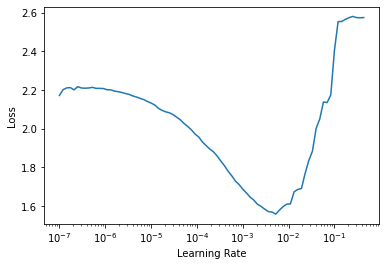

In [0]:
learn.lr_find()

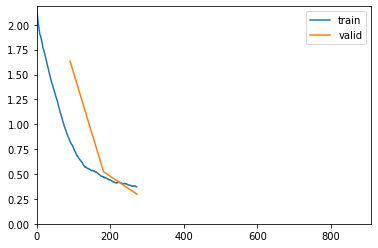

IndexError: ignored

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 4e-4)

# Basic Counting using RESNET 1D

In [0]:
def generate_simple_dataset(n, length=18310):
  data = L()
  for i in range(n):
    # if i%50 == 0 : print(i)
    no_snaps = random.randint(0, 10)
    idxs= torch.randint(0,length,(no_snaps,))
    sequence = torch.zeros([length])
    sequence[idxs] = 1

    data += L([(sequence.unsqueeze(0),tensor(no_snaps).float())])#
  cut = int(.8*n)
  train_ds = data[:cut]
  valid_ds = data[cut:]
  return train_ds , valid_ds 

In [0]:
ds_t,ds_v = generate_simple_dataset(20000)

In [0]:
dls = DataLoaders.from_dsets(ds_t, ds_v, bs=128, shuffle=True, drop_last=True, ) 
dls.to('cuda')

In [0]:
x.shape

torch.Size([128, 1, 18310])

In [0]:
kernel_size = 15
stride = 4

net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2, 2, 2],
    "kernel_size": kernel_size,
    "stride": stride,
    "num_classes": 1
}
model = ResNet(**net_args)

In [0]:
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=accuracy, cbs=ShowGraphCallback())

In [0]:
learn.summary()

ResNet (Input shape: ['128 x 1 x 18310'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               128 x 16 x 18310     48         True      
________________________________________________________________
BatchNorm1d          128 x 16 x 18310     32         True      
________________________________________________________________
Conv1d               128 x 16 x 18310     3,840      True      
________________________________________________________________
BatchNorm1d          128 x 16 x 18310     32         True      
________________________________________________________________
ReLU                 128 x 16 x 18310     0          False     
________________________________________________________________
Conv1d               128 x 16 x 18310     3,840      True      
________________________________________________________________
BatchNorm1d          128 x 16 x 18310     32         True      
________________________________________________________

SuggestedLRs(lr_min=0.003981071710586548, lr_steep=3.630780702224001e-05)

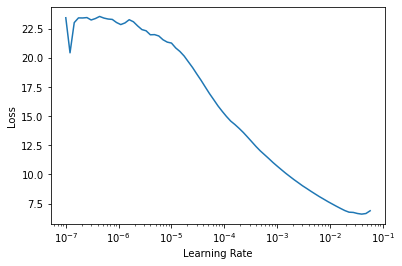

In [0]:
learn.lr_find()

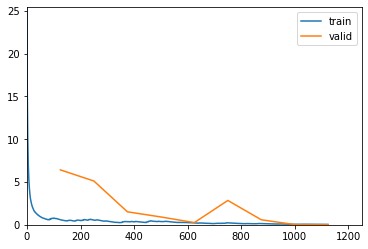

IndexError: ignored

In [0]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2)

In [0]:
learn.get_preds()

(tensor([[7.0863],
         [6.0444],
         [5.0701],
         ...,
         [3.0720],
         [4.0510],
         [2.0281]]), tensor([7., 6., 5.,  ..., 3., 4., 2.]))

# Counting simulated shrimp snaps

In [0]:
def snaps(snaps = 1, length=1, rate=18310, fixed=False):
  length = int(length * rate)
  base = torch.zeros(length)
  if snaps == 0: return tensor(base)
  for i in range(snaps): 
    decay= torch.FloatTensor(1,).uniform_(5, 5)
    freq= torch.FloatTensor(1,).uniform_(1800, 2000) #49.825
    amplitude = torch.FloatTensor(1,).uniform_(.6, 1)
    snap = amplitude*torch.exp(-.03*torch.arange(0, 200))*torch.sin(2*3.1415*freq/rate*torch.arange(0, 200))
    if fixed:
      base[200:400] += snap
      noise_amp = .1*amplitude
      base += noise_amp * torch.empty(base.shape).normal_()
      return tensor(base)
    start =  torch.randint(200, int(length-500), (1,))
    noise_amp = .1*amplitude
    base += noise_amp * torch.empty(base.shape).normal_()
    base[start:start+200] += snap 
  return tensor(base)

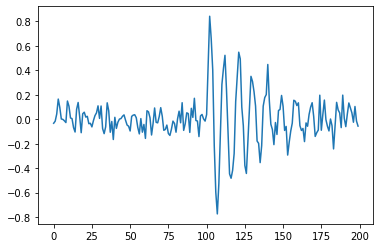

In [0]:
plt.plot(snaps(1, fixed=True)[100:300])

In [0]:
def generate_snappy_dataset(n, length=2000):
  data = L()
  for i in range(n):
    # if i%50 == 0 : print(i)
    no_snaps = random.randint(0,  10)
    data += L([(snaps(no_snaps).unsqueeze(0),tensor(no_snaps).float())])
  cut = int(.8*n)
  train_ds = data[:cut]
  valid_ds = data[cut:]
  return train_ds , valid_ds 

In [0]:
ds_t,ds_v = generate_snappy_dataset(20000)

In [0]:
dls = DataLoaders.from_dsets(ds_t, ds_v, bs=128, shuffle=True, drop_last=True, ) 
dls.to('cuda')

In [0]:
x,y =dls.one_batch()

In [0]:
x.shape

torch.Size([128, 1, 18310])

In [0]:
kernel_size = 15
stride = 4

net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2, 2, 2],
    "kernel_size": kernel_size,
    "stride": stride,
    "num_classes": 1
}
model = ResNet(**net_args)

In [0]:
learn = Learner(dls, model, loss_func=MSELossFlat(), metrics=mse, cbs=ShowGraphCallback())

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.0006918309954926372)

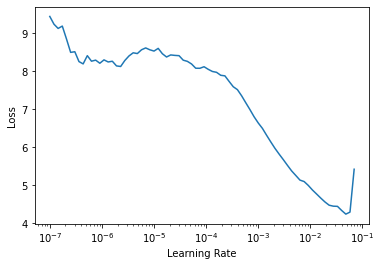

In [0]:
learn.lr_find()

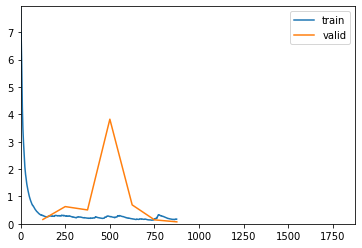

IndexError: ignored

In [0]:
learn.unfreeze()
learn.fit_one_cycle(15, 1e-2)

In [0]:
learn.get_preds()

(tensor([[ 2.9993e+00],
         [ 4.0724e+00],
         [ 7.9679e+00],
         ...,
         [ 5.8642e+00],
         [-3.0785e-03],
         [-3.0785e-03]]), tensor([3., 4., 8.,  ..., 6., 0., 0.]))